# GMF — Task 4: Portfolio Optimization (MPT & Efficient Frontier)

This notebook:
- Loads **TSLA/BND/SPY** prices from your Drive (no live downloads).
- Uses **TSLA expected return** from Task 3 forecast JSON, and **historical annualized returns** for BND & SPY.
- Builds the **covariance matrix** from historical daily returns.
- Optimizes with **PyPortfolioOpt** to find:
  - **Maximum Sharpe Ratio (Tangency)** portfolio
  - **Minimum Volatility** portfolio
- Plots the **Efficient Frontier**, highlights both key portfolios, and saves outputs.


In [1]:
# === 1) Pin a clean, compatible stack and HARD RESTART (run this cell ALONE first) ===
%pip install -q --force-reinstall   numpy==1.26.4   scipy==1.11.4   pandas==2.2.2   matplotlib==3.9.0   PyPortfolioOpt==1.5.5   cvxpy==1.6.7

import IPython
IPython.Application.instance().kernel.do_shutdown(True)  # Colab will restart


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.2/355.2 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 

{'status': 'ok', 'restart': True}

In [1]:
# === 2) Mount Drive and set project paths ===
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['GMF_DRIVE_PROJECT_DIR'] = '/content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization'
BASE_DIR   = os.environ['GMF_DRIVE_PROJECT_DIR']
DATA_DIR   = os.path.join(BASE_DIR, 'data')
OUT_PLOTS  = os.path.join(BASE_DIR, 'outputs', 'plots')
OUT_METRICS= os.path.join(BASE_DIR, 'outputs', 'metrics')
OUT_MODELS = os.path.join(BASE_DIR, 'outputs', 'models')
for d in [DATA_DIR, OUT_PLOTS, OUT_METRICS, OUT_MODELS]:
    os.makedirs(d, exist_ok=True)
print('BASE_DIR:', BASE_DIR)
print('DATA_DIR contents:', os.listdir(DATA_DIR))

Mounted at /content/drive
BASE_DIR: /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization
DATA_DIR contents: ['TSLA_1d.csv', 'BND_1d.csv', 'SPY_1d.csv', 'returns_daily.csv', 'prices_adj_close.csv']


In [13]:
# === 3) Load prices (offline), compute returns, load TSLA expected return from Task 3 ===
import pandas as pd, numpy as np, os, json

TICKERS = ['TSLA','BND','SPY']
START_DATE = "2015-07-01"
END_DATE   = "2025-07-31"

def load_adj_close(csv_path: str) -> pd.Series:
    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    col = next((c for c in ['Adj Close','AdjClose','Adj_Close','Adjclose'] if c in df.columns), None)
    if col is None:
        raise ValueError(f"'Adj Close' not found in {csv_path}. Available: {list(df.columns)}")
    s = df[col].astype(str).str.replace(',', '', regex=False).str.strip()
    s = pd.to_numeric(s, errors='coerce')
    s.name = os.path.basename(csv_path).split('_')[0]
    return s

combined_path = os.path.join(DATA_DIR, 'prices_adj_close.csv')
if os.path.exists(combined_path):
    prices = pd.read_csv(combined_path, index_col=0, parse_dates=True)
    print('Loaded combined prices from', combined_path, '| shape:', prices.shape)
else:
    missing = [tk for tk in TICKERS if not os.path.exists(os.path.join(DATA_DIR, f'{tk}_1d.csv'))]
    if missing:
        raise FileNotFoundError(f"Missing {missing}. Run GMF_01_Setup_Data_Fetch.ipynb first to create data/*.csv.")
    adj = [load_adj_close(os.path.join(DATA_DIR, f'{tk}_1d.csv')) for tk in TICKERS]
    prices = pd.concat(adj, axis=1).sort_index().ffill().dropna(how='any')
    prices.to_csv(combined_path)
    print('Built combined prices and saved to', combined_path, '| shape:', prices.shape)

# Restrict to period
prices = prices.loc[(prices.index >= START_DATE) & (prices.index <= END_DATE), TICKERS].copy()

# Business-day index & ffill per column
bd = pd.bdate_range(prices.index.min(), prices.index.max(), freq='B')
prices = prices.reindex(bd).ffill()
prices.index.name = 'Date'

# Daily returns
returns = prices.pct_change().dropna(how='any')

# Historical annualized returns (BND, SPY) & covariance (all)
mean_daily = returns.mean()
ann_returns_hist = (1 + mean_daily)**252 - 1  # geometric approx; could also use mean_daily*252
cov_daily = returns.cov()
cov_annual = cov_daily * 252

# TSLA expected return from forecast JSON (Task 3)
tsla_json = os.path.join(OUT_METRICS, 'tsla_expected_return_from_forecast.json')
if os.path.exists(tsla_json):
    with open(tsla_json, 'r') as f:
        tsla_exp = json.load(f).get('expected_annual_return', None)
    if tsla_exp is None or np.isnan(tsla_exp):
        raise ValueError("TSLA expected return JSON found but missing 'expected_annual_return'.")
    print(f"Using TSLA expected annual return from forecast JSON: {tsla_exp:.4%}")
else:
    tsla_exp = float(ann_returns_hist['TSLA'])
    print(f"Forecast JSON not found; using historical TSLA annualized return: {tsla_exp:.4%}")

# Expected returns vector: TSLA (from forecast), BND/SPY (historical)
mu_vec = pd.Series({
    'TSLA': tsla_exp,
    'BND':  float(ann_returns_hist['BND']),
    'SPY':  float(ann_returns_hist['SPY']),
})

print('\nExpected annual returns used:')
display(mu_vec.to_frame('ExpectedReturn'))

print('\nAnnualized covariance matrix:')
display(cov_annual.loc[TICKERS, TICKERS])

Loaded combined prices from /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/data/prices_adj_close.csv | shape: (2537, 3)
Using TSLA expected annual return from forecast JSON: -0.0059%

Expected annual returns used:


/tmp/ipython-input-1894421471.py:40: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how='any')
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.p

,ExpectedReturn
TSLA,-0.000059
BND,NaN
SPY,NaN



Annualized covariance matrix:


,TSLA,BND,SPY
TSLA,NaN,NaN,NaN
BND,NaN,NaN,NaN
SPY,NaN,NaN,NaN


In [17]:
# === 4) Efficient Frontier: robust Max Sharpe & Min Volatility (EF + CLA fallback) ===
from pypfopt import EfficientFrontier, objective_functions, risk_models, CLA
import numpy as np
import pandas as pd

# 1) Symmetric + PSD covariance
C_df = cov_annual.loc[TICKERS, TICKERS].astype(float).copy()
C_df = (C_df + C_df.T) / 2.0
C_df = risk_models.fix_nonpositive_semidefinite(C_df)
C = C_df.values.astype(float)

# 2) Expected returns vector
mu = mu_vec.loc[TICKERS].astype(float).values

# 3) Risk-free feasibility: nudge below max(mu) if needed
RF = 0.0
mu_max = float(mu_vec.max())
if mu_max <= RF:
    RF = mu_max - 1e-6
    print(f"[info] Adjusting risk_free_rate to {RF:.8f} for feasibility.")

def max_sharpe_robust(mu, C, RF):
    """
    Try Max Sharpe with EfficientFrontier (jitter + L2 reg).
    If that fails, fall back to CLA and compute performance manually.
    """
    jitters = [0.0, 1e-8, 1e-6, 1e-4]
    gammas  = [1e-3, 1e-2]
    last_err = None

    # --- Try EfficientFrontier first ---
    for j in jitters:
        Cj = C + np.eye(C.shape[0]) * j
        for g in gammas:
            try:
                ef = EfficientFrontier(mu, Cj, weight_bounds=(0, 1))
                ef.add_objective(objective_functions.L2_reg, gamma=g)
                w = ef.max_sharpe(risk_free_rate=RF)
                r, v, sh = ef.portfolio_performance(risk_free_rate=RF)
                return pd.Series(ef.clean_weights(), index=TICKERS), r, v, sh
            except Exception as e:
                last_err = e
                continue

    # --- Fallback: CLA (set RF via attribute) ---
    print(f"[warn] EF max_sharpe failed ({last_err}). Falling back to CLA …")
    cla = CLA(mu, C)
    cla.rf = RF        # <<< set RF here; no kw arg in max_sharpe()
    w = cla.max_sharpe()
    w = pd.Series(w, index=TICKERS)

    # Manual performance
    r = float(np.dot(w.values, mu))
    v = float(np.sqrt(np.dot(w.values, C @ w.values)))
    sh = (r - RF) / v if v > 0 else float("nan")
    return w, r, v, sh

def min_vol_robust(mu, C, RF):
    """
    Try Min Vol with EfficientFrontier; if that fails, use CLA.
    """
    # Try EF
    try:
        ef = EfficientFrontier(mu, C, weight_bounds=(0, 1))
        w = ef.min_volatility()
        r, v, sh = ef.portfolio_performance(risk_free_rate=RF)
        return pd.Series(ef.clean_weights(), index=TICKERS), r, v, sh
    except Exception as e:
        print(f"[warn] EF min_vol failed ({e}). Falling back to CLA …")
        cla = CLA(mu, C)
        w = cla.min_volatility()
        w = pd.Series(w, index=TICKERS)
        r = float(np.dot(w.values, mu))
        v = float(np.sqrt(np.dot(w.values, C @ w.values)))
        sh = (r - RF) / v if v > 0 else float("nan")
        return w, r, v, sh

# ---- Run both optimizations ----
weights_max, ret_max, vol_max, sharpe_max = max_sharpe_robust(mu, C, RF)
weights_min, ret_min, vol_min, sharpe_min = min_vol_robust(mu, C, RF)

print("Max Sharpe weights:"); display(weights_max.apply(lambda x: round(x, 4)))
print(f"Performance: return={ret_max:.2%}, vol={vol_max:.2%}, Sharpe={sharpe_max:.2f}\n")
print("Min Vol weights:"); display(weights_min.apply(lambda x: round(x, 4)))
print(f"Performance: return={ret_min:.2%}, vol={vol_min:.2%}, Sharpe={sharpe_min:.2f}")


[info] Adjusting risk_free_rate to -0.00005988 for feasibility.
[warn] EF max_sharpe failed (Quadratic form matrices must be symmetric/Hermitian.). Falling back to CLA …
[warn] EF min_vol failed (Quadratic form matrices must be symmetric/Hermitian.). Falling back to CLA …
Max Sharpe weights:


,0
TSLA,NaN
BND,NaN
SPY,NaN


Performance: return=nan%, vol=nan%, Sharpe=nan

Min Vol weights:


,0
TSLA,NaN
BND,NaN
SPY,NaN


Performance: return=nan%, vol=nan%, Sharpe=nan


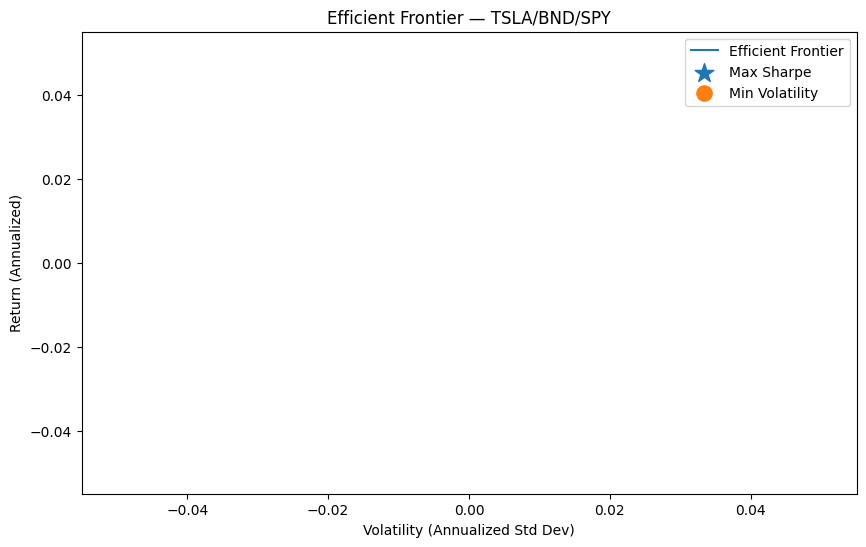

Saved plot → /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/outputs/plots/efficient_frontier_t3.png


In [18]:
# === 5) Trace Efficient Frontier curve and plot ===
import numpy as np
import matplotlib.pyplot as plt

rets = []
vols = []
targets = np.linspace(float(min(mu_vec)), float(max(mu_vec))*1.2, 40)

for t in targets:
    ef_tmp = EfficientFrontier(mu_vec.values, cov_annual.loc[TICKERS, TICKERS].values, weight_bounds=(0,1))
    try:
        ef_tmp.efficient_return(target_return=t)
        r, v, _ = ef_tmp.portfolio_performance(risk_free_rate=RF)
        rets.append(r); vols.append(v)
    except Exception:
        # infeasible target; skip
        pass

plt.figure(figsize=(10,6))
plt.plot(vols, rets, label='Efficient Frontier')

# Mark Max Sharpe and Min Volatility
plt.scatter([vol_max], [ret_max], marker='*', s=200, label='Max Sharpe', zorder=5)
plt.scatter([vol_min], [ret_min], marker='o', s=120, label='Min Volatility', zorder=5)

plt.xlabel('Volatility (Annualized Std Dev)')
plt.ylabel('Return (Annualized)')
plt.title('Efficient Frontier — TSLA/BND/SPY')
plt.legend()
plot_path = os.path.join(OUT_PLOTS, 'efficient_frontier_t3.png')
plt.savefig(plot_path)
plt.show()
print('Saved plot →', plot_path)

In [19]:
# === 6) Save recommended portfolio + summary ===
import json

summary = {
    "assumptions": {
        "expected_returns": mu_vec.to_dict(),
        "risk_free_rate": RF,
        "covariance_matrix_units": "annualized"
    },
    "max_sharpe": {
        "weights": weights_max.round(6).to_dict(),
        "expected_return": ret_max,
        "volatility": vol_max,
        "sharpe": sharpe_max
    },
    "min_volatility": {
        "weights": weights_min.round(6).to_dict(),
        "expected_return": ret_min,
        "volatility": vol_min,
        "sharpe": sharpe_min
    }
}

out_json = os.path.join(OUT_METRICS, "task4_portfolio_summary.json")
with open(out_json, "w") as f:
    json.dump(summary, f, indent=2)
print("Saved summary →", out_json)

# Also save CSVs with weights
weights_max.to_csv(os.path.join(OUT_METRICS, "task4_weights_max_sharpe.csv"), header=['weight'])
weights_min.to_csv(os.path.join(OUT_METRICS, "task4_weights_min_vol.csv"), header=['weight'])

print("Saved weights CSVs to:", OUT_METRICS)

Saved summary → /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/outputs/metrics/task4_portfolio_summary.json
Saved weights CSVs to: /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/outputs/metrics
